In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 0. Data loading


In [2]:
# Load daily consumption (telelectura)
df_consum = pd.read_parquet("data/consum_telelectura_anonymized.parquet")

df_consum.head()

,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,SECCIO_CENSAL,US_AIGUA_GEST,NUM_MUN_SGAB,NUM_DTE_MUNI,NUM_COMPLET,DATA_INST_COMP,MARCA_COMP,CODI_MODEL,DIAM_COMP
0,VECWAVDUULZDSBOP,2021-01-01,1758,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
1,VECWAVDUULZDSBOP,2021-01-02,1854,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
2,VECWAVDUULZDSBOP,2021-01-03,1885,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
3,VECWAVDUULZDSBOP,2021-01-04,5676,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
4,VECWAVDUULZDSBOP,2021-01-05,4456,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0


In [ ]:
# Load leak incidents and client communications
df_fuites = pd.read_parquet("data/consum_avisos_missatges_anonymized.parquet")

df_fuites.head()

In [12]:
# Dataset renda mitjana per districte (Ajuntament de Barcelona)
df_socio = pd.read_csv("data/renda_districte.csv", sep=",")
df_socio.head()

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_Censal,Import_Euros
0,2022,1,Ciutat Vella,1,el Raval,1,15940
1,2022,1,Ciutat Vella,1,el Raval,2,13841
2,2022,1,Ciutat Vella,1,el Raval,3,12732
3,2022,1,Ciutat Vella,1,el Raval,4,15749
4,2022,1,Ciutat Vella,1,el Raval,5,13190


In [13]:
# Load daily meteorology (Fabra station)
df_meteo = pd.read_csv("data/fabra_diari.txt", sep="\t", skiprows=12)

# Filter rows where ANY is between 2022 and 2024 (both included)
df_meteo = df_meteo[(df_meteo["ANY"] >= 2022) & (df_meteo["ANY"] <= 2024)]

# Drop the "INS" column
df_meteo = df_meteo.drop(columns=["INS"])

# Basic harmonization
df_meteo.rename(columns={"ANY": "year", "MES": "month", "DIA": "day"}, inplace=True)
df_meteo[["year", "month", "day"]] = df_meteo[["year", "month", "day"]].astype(int)
df_meteo["Data"] = pd.to_datetime(df_meteo[["year", "month", "day"]])

df_meteo.head()

,year,month,day,PPT,TX,TN,Data
26298,2022,1,1,0.0,22.1,14.9,2022-01-01
26299,2022,1,2,0.0,16.4,9.6,2022-01-02
26300,2022,1,3,0.0,17.1,12.2,2022-01-03
26301,2022,1,4,10.1,21.1,10.1,2022-01-04
26302,2022,1,5,0.4,11.0,5.7,2022-01-05


In [ ]:
# Build a quick data dictionary for the loaded datasets
from IPython.display import display

datasets = {
    "consum": df_consum,
    "fuites": df_fuites,
    "meteo": df_meteo,
    "socio": df_socio,
}

# Create summary statistics DataFrames for each dataset
for name, df in datasets.items():
    print(f"\n{'='*80}")
    print(f"Dataset: {name.upper()}")
    print(f"{'='*80}")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]}")
    print(f"Overall missing (%): {round(df.isna().mean().mean() * 100, 2)}%")
    print()
    
    # Create DataFrame with column statistics
    stats_data = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        miss = round(df[col].isna().mean() * 100, 2)
        nunq = df[col].nunique()
        ex = ""
        if df[col].notna().any():
            try:
                ex = str(df[col].dropna().iloc[0])[:80]
            except Exception:
                ex = ""
        stats_data.append({
            "Column": col,
            "Dtype": dtype,
            "Missing (%)": miss,
            "#Unique": nunq,
            "Example": ex
        })
    
    stats_df = pd.DataFrame(stats_data)
    display(stats_df)
    print()

# 1. Data cleaning


In [ ]:
# df_consum
# Convert FECHA and DATA_INST_COMP to datetime
for date_col in ["FECHA", "DATA_INST_COMP"]:
    if date_col in df_consum.columns:
        df_consum[date_col] = pd.to_datetime(df_consum[date_col], errors="coerce")

In [9]:
# df_fuites
# Convert DATA_INI_FACT and DATA_FIN_FACT to datetime
for date_col in ["DATA_INI_FACT", "DATA_FIN_FACT"]:
    if date_col in df_fuites.columns:
        df_fuites[date_col] = pd.to_datetime(df_fuites[date_col], errors="coerce")


In [10]:
df_consum.isnull().sum()

POLIZA_SUMINISTRO           0
FECHA                       0
CONSUMO_REAL                0
SECCIO_CENSAL        11312709
US_AIGUA_GEST        11312709
NUM_MUN_SGAB         11312709
NUM_DTE_MUNI         11312709
NUM_COMPLET          11312709
DATA_INST_COMP       11312709
MARCA_COMP           11312709
CODI_MODEL           11312709
DIAM_COMP            11312709
dtype: int64

In [11]:
df_fuites.isnull().sum()

POLISSA_SUBM                  0
DATA_INI_FACT                 0
DATA_FIN_FACT                 0
CREATED_MENSAJE        23318973
CODIGO_MENSAJE         23318973
TIPO_MENSAJE           23318973
US_AIGUA_SUBM                 0
SECCIO_CENSAL           1352683
NUMEROSERIECONTADOR           0
CONSUMO_REAL           13067221
FECHA_HORA                    0
dtype: int64

## 1.1 Handle Missing values 

In [13]:
# Check if each POLIZA_SUMINISTRO has a unique SECCIO_CENSAL
consistency = df_consum.groupby('POLIZA_SUMINISTRO')['SECCIO_CENSAL'].nunique()
print((consistency > 1).sum(), "policies have multiple census sections")

0 policies have multiple census sections


In [ ]:
# Keep only relevant columns
cols_keep_consum = [
    'POLIZA_SUMINISTRO', 'FECHA', 'CONSUMO_REAL', 'SECCIO_CENSAL', 'US_AIGUA_GEST'
]
df_consum_clean = df_consum[cols_keep_consum].copy()

# 1. Impute US_AIGUA_GEST within each POLIZA_SUMINISTRO group
df_consum_clean['US_AIGUA_GEST'] = (
    df_consum_clean.groupby('POLIZA_SUMINISTRO')['US_AIGUA_GEST']
    .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
)

# 2. Impute SECCIO_CENSAL within each POLIZA_SUMINISTRO group
df_consum_clean['SECCIO_CENSAL'] = (
    df_consum_clean.groupby('POLIZA_SUMINISTRO')['SECCIO_CENSAL']
    .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
)

# 3. Filter to keep only SECCIO_CENSAL starting with '8019' which corresponds to Barcelona
df_consum_clean['SECCIO_CENSAL'] = pd.to_numeric(df_consum_clean['SECCIO_CENSAL'], errors='coerce').astype('Int64')
mask_bcn = df_consum_clean['SECCIO_CENSAL'].astype(str).str.startswith('8019', na=False)
df_consum_clean = df_consum_clean[mask_bcn].copy()

# 4. Fallback: if still missing after imputation, fill with 'Unknown'
df_consum_clean['US_AIGUA_GEST'] = df_consum_clean['US_AIGUA_GEST'].fillna('Unknown')

# 5. Ensure correct types
df_consum_clean['FECHA'] = pd.to_datetime(df_consum_clean['FECHA'], errors='coerce')
df_consum_clean['CONSUMO_REAL'] = pd.to_numeric(df_consum_clean['CONSUMO_REAL'], errors='coerce')


# 6. Save cleaned dataset to Parquet
output_path = "clean/consum_clean_full.parquet"
df_consum_clean.to_parquet(output_path, index=False)

print("df_consum cleaned:", df_consum_clean.shape)


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_15819/741722748.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_15819/741722748.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


✅ df_consum cleaned: (1555356, 5)


In [45]:
df_consum_clean.isnull().sum()

POLIZA_SUMINISTRO    0
FECHA                0
CONSUMO_REAL         0
SECCIO_CENSAL        0
US_AIGUA_GEST        0
dtype: int64

In [ ]:
# Keep only relevant columns
cols_keep_fuites = [
    'POLISSA_SUBM', 'DATA_INI_FACT', 'DATA_FIN_FACT',
    'CREATED_MENSAJE', 'CODIGO_MENSAJE', 'TIPO_MENSAJE',
    'US_AIGUA_SUBM', 'SECCIO_CENSAL', 'NUMEROSERIECONTADOR',
    'CONSUMO_REAL', 'FECHA_HORA'
]
df_fuites_clean = df_fuites[cols_keep_fuites].copy()

# 1. Impute SECCIO_CENSAL within each POLISSA_SUBM group (same logic as df_consum)
df_fuites_clean['SECCIO_CENSAL'] = (
    df_fuites_clean.groupby('POLISSA_SUBM')['SECCIO_CENSAL']
    .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
)

# 2. Replace missing consumption with 0 (to keep all records)
df_fuites_clean['CONSUMO_REAL'] = df_fuites_clean['CONSUMO_REAL'].fillna(0)

# 3. Convert datatypes
df_fuites_clean['DATA_INI_FACT'] = pd.to_datetime(df_fuites_clean['DATA_INI_FACT'], errors='coerce')
df_fuites_clean['DATA_FIN_FACT'] = pd.to_datetime(df_fuites_clean['DATA_FIN_FACT'], errors='coerce')
df_fuites_clean['FECHA_HORA'] = pd.to_datetime(df_fuites_clean['FECHA_HORA'], errors='coerce')
df_fuites_clean['CONSUMO_REAL'] = pd.to_numeric(df_fuites_clean['CONSUMO_REAL'], errors='coerce')

# 4. Filter to keep only SECCIO_CENSAL starting with '8019' which corresponds to Barcelona
df_fuites_clean['SECCIO_CENSAL'] = pd.to_numeric(df_fuites_clean['SECCIO_CENSAL'], errors='coerce').astype('Int64')
df_fuites_clean = df_fuites_clean[df_fuites_clean['SECCIO_CENSAL'].astype(str).str.startswith('8019', na=False)]

# 5. Handle TIPO_MENSAJE and CODIGO_MENSAJE if needed
df_fuites_clean['CODIGO_MENSAJE'] = df_fuites_clean['CODIGO_MENSAJE'].fillna('Unknown')
df_fuites_clean['TIPO_MENSAJE'] = df_fuites_clean['TIPO_MENSAJE'].fillna('Unknown')

# 5. Save cleaned dataset
output_path = "clean/fuites_clean_full.parquet"
df_fuites_clean.to_parquet(output_path, index=False)

print(f" df_fuites cleaned and saved successfully: {df_fuites_clean.shape}")

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_15819/2553298105.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


✅ df_fuites cleaned and saved successfully: (75019565, 11)


In [42]:
df_fuites_clean.isnull().sum()

POLISSA_SUBM                  0
DATA_INI_FACT                 0
DATA_FIN_FACT                 0
CREATED_MENSAJE        23171517
CODIGO_MENSAJE                0
TIPO_MENSAJE                  0
US_AIGUA_SUBM                 0
SECCIO_CENSAL                 0
NUMEROSERIECONTADOR           0
CONSUMO_REAL                  0
FECHA_HORA                    0
dtype: int64

In [5]:
# Load cleaned datasets directly
df_consum_clean = pd.read_parquet("clean/consum_clean_full.parquet")
df_fuites_clean = pd.read_parquet("clean/fuites_clean_full.parquet")


## 2. Merging

In [6]:
# Consumption per census section and day
df_consum_agg = (
    df_consum_clean
    .groupby(['SECCIO_CENSAL', 'FECHA'])
    .agg({'CONSUMO_REAL': 'sum'})
    .reset_index()
)
df_consum_agg.head()

,SECCIO_CENSAL,FECHA,CONSUMO_REAL
0,801901001,2021-01-01,219
1,801901001,2021-01-02,312
2,801901001,2021-01-03,362
3,801901001,2021-01-04,281
4,801901001,2021-01-05,256


In [7]:
df_consum_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359213 entries, 0 to 359212
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   SECCIO_CENSAL  359213 non-null  Int64         
 1   FECHA          359213 non-null  datetime64[us]
 2   CONSUMO_REAL   359213 non-null  int64         
dtypes: Int64(1), datetime64[us](1), int64(1)
memory usage: 8.6 MB


In [8]:
# Leak frequency per census section and month
df_fuites_agg = (
    df_fuites_clean
    .assign(month=df_fuites_clean['FECHA_HORA'].dt.to_period('M'))
    .groupby(['SECCIO_CENSAL', 'month'])
    .size()
    .reset_index(name='num_fuites')
)

In [9]:
df_fuites_agg.head()

,SECCIO_CENSAL,month,num_fuites
0,801901002,2024-01,6720
1,801901002,2024-02,6368
2,801901002,2024-03,6712
3,801901002,2024-04,6480
4,801901002,2024-05,6720


In [11]:
df_fuites_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10807 entries, 0 to 10806
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   SECCIO_CENSAL  10807 non-null  Int64    
 1   month          10807 non-null  period[M]
 2   num_fuites     10807 non-null  int64    
dtypes: Int64(1), int64(1), period[M](1)
memory usage: 264.0 KB


In [87]:
## NO ESTIC SEGURA D'AQUEST ÚLTIM

In [14]:
for name, df in {
    "df_socio": df_socio,
    "df_consum_agg": df_consum_agg,
    "df_fuites_agg": df_fuites_agg
}.items():
    print(f"{name} columns:", list(df.columns))

df_socio columns: ['Any', 'Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri', 'Seccio_Censal', 'Import_Euros']
df_consum_agg columns: ['SECCIO_CENSAL', 'FECHA', 'CONSUMO_REAL']
df_fuites_agg columns: ['SECCIO_CENSAL', 'month', 'num_fuites']


In [15]:
# Normalize column names for consistency
df_socio = df_socio.rename(columns={
    'Seccio_Censal': 'SECCIO_CENSAL'
})

In [16]:
df_socio['SECCIO_CENSAL'] = (
    '8019' +
    df_socio['Codi_Districte'].astype(int).astype(str).str.zfill(2) +
    df_socio['SECCIO_CENSAL'].astype(int).astype(str).str.zfill(3)
)

In [17]:
print("Unique sections:", df_socio['SECCIO_CENSAL'].nunique())
print("Rows:", len(df_socio))

Unique sections: 1068
Rows: 1068


In [18]:
print(df_socio['SECCIO_CENSAL'].head())
print(df_socio['SECCIO_CENSAL'].dtype)

0    801901001
1    801901002
2    801901003
3    801901004
4    801901005
Name: SECCIO_CENSAL, dtype: object
object


In [19]:
print(df_socio['SECCIO_CENSAL'].dtype)
print(df_consum_agg['SECCIO_CENSAL'].dtype)
print(df_fuites_agg['SECCIO_CENSAL'].dtype)

object
Int64
Int64


In [20]:
# in order to do the merge we unify them all to string
df_socio['SECCIO_CENSAL'] = df_socio['SECCIO_CENSAL'].astype(str)
df_consum_agg['SECCIO_CENSAL'] = df_consum_agg['SECCIO_CENSAL'].astype(str)
df_fuites_agg['SECCIO_CENSAL'] = df_fuites_agg['SECCIO_CENSAL'].astype(str)

In [21]:
# Merge socio + average consumption + averge leakas
for df in [df_socio, df_consum_agg, df_fuites_agg]:
    df['SECCIO_CENSAL'] = df['SECCIO_CENSAL'].astype(str)

df_vulnerability = (
    df_socio
    .merge(df_consum_agg.groupby('SECCIO_CENSAL')['CONSUMO_REAL'].mean().reset_index(),
           on='SECCIO_CENSAL', how='left')
    .merge(df_fuites_agg.groupby('SECCIO_CENSAL')['num_fuites'].sum().reset_index(),
           on='SECCIO_CENSAL', how='left')
)

df_vulnerability.head()

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,SECCIO_CENSAL,Import_Euros,CONSUMO_REAL,num_fuites
0,2022,1,Ciutat Vella,1,el Raval,801901001,15940,787.013049,NaN
1,2022,1,Ciutat Vella,1,el Raval,801901002,13841,NaN,79448.0
2,2022,1,Ciutat Vella,1,el Raval,801901003,12732,264.962861,35272.0
3,2022,1,Ciutat Vella,1,el Raval,801901004,15749,NaN,120651.0
4,2022,1,Ciutat Vella,1,el Raval,801901005,13190,NaN,193310.0


In [22]:
df_vulnerability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Any             1068 non-null   int64  
 1   Codi_Districte  1068 non-null   int64  
 2   Nom_Districte   1068 non-null   object 
 3   Codi_Barri      1068 non-null   int64  
 4   Nom_Barri       1068 non-null   object 
 5   SECCIO_CENSAL   1068 non-null   object 
 6   Import_Euros    1068 non-null   int64  
 7   CONSUMO_REAL    247 non-null    float64
 8   num_fuites      918 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 75.2+ KB


## 3. Data Validation

In [23]:
#validation for df_socio
print("df_socio")
print("Rows:", len(df_socio))
print("Duplicate SECCIO_CENSAL:", df_socio['SECCIO_CENSAL'].duplicated().sum())
print("Missing SECCIO_CENSAL:", df_socio['SECCIO_CENSAL'].isna().sum())

# Check format of SECCIO_CENSAL
invalid_codes = df_socio[~df_socio['SECCIO_CENSAL'].astype(str).str.match(r"^8019\d{5}$")]
print("Invalid codes:", len(invalid_codes))


df_socio
Rows: 1068
Duplicate SECCIO_CENSAL: 0
Missing SECCIO_CENSAL: 0
Invalid codes: 0


In [25]:
#validation for df_consum_agg
print("df_consum_agg")
print("Missing values:\n", df_consum_agg.isna().sum())
print("Duplicates per SECCIO_CENSAL + FECHA:", 
      df_consum_agg.duplicated(subset=['SECCIO_CENSAL', 'FECHA']).sum())

# Check negative 
negatives = (df_consum_agg['CONSUMO_REAL'] < 0).sum()
print("Negative consumption entries:", negatives)


df_consum_agg
Missing values:
 SECCIO_CENSAL    0
FECHA            0
CONSUMO_REAL     0
dtype: int64
Duplicates per SECCIO_CENSAL + FECHA: 0
Negative consumption entries: 0


In [27]:
print("df_fuites_agg")
print("Missing values:\n", df_fuites_agg.isna().sum())
print("Duplicates per SECCIO_CENSAL + month:",
      df_fuites_agg.duplicated(subset=['SECCIO_CENSAL', 'month']).sum())

# Logical validation
print("Negative or zero leaks:", (df_fuites_agg['num_fuites'] < 0).sum())
print("Month range:", df_fuites_agg['month'].min(), "-", df_fuites_agg['month'].max())


df_fuites_agg
Missing values:
 SECCIO_CENSAL    0
month            0
num_fuites       0
dtype: int64
Duplicates per SECCIO_CENSAL + month: 0
Negative or zero leaks: 0
Month range: 2024-01 - 2024-12


df_vulnerability
Missing values (%):
 Any                0.000000
Codi_Districte     0.000000
Nom_Districte      0.000000
Codi_Barri         0.000000
Nom_Barri          0.000000
SECCIO_CENSAL      0.000000
Import_Euros       0.000000
CONSUMO_REAL      76.872659
num_fuites        14.044944
dtype: float64


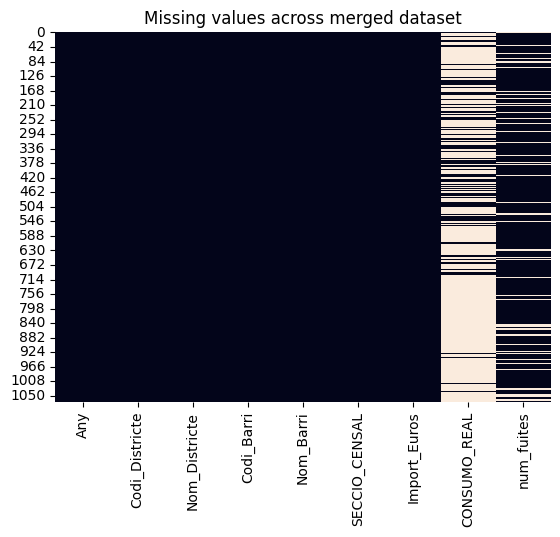

In [28]:
print("df_vulnerability")
print("Missing values (%):\n", df_vulnerability.isna().mean() * 100)

# Check merge success
sns.heatmap(df_vulnerability.isna(), cbar=False)
plt.title("Missing values across merged dataset")
plt.show()


## 4. Correlation and trend analysis

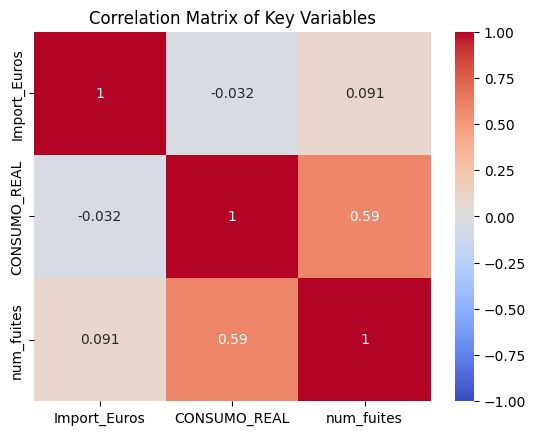

In [ ]:
#COMPUTE CORRELATIONS

# Select relevant numeric columns
corr_vars = ['Import_Euros', 'CONSUMO_REAL', 'num_fuites']

corr_matrix = df_vulnerability[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Key Variables")
plt.show()

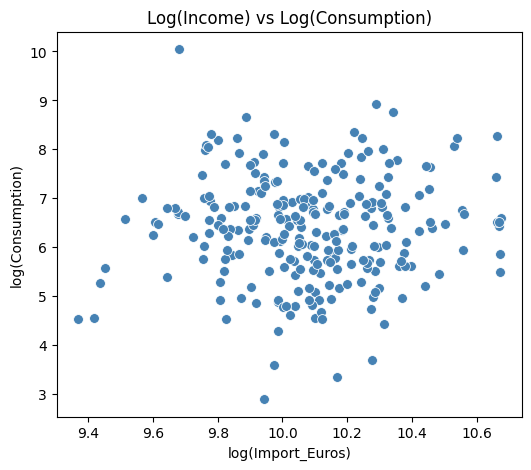

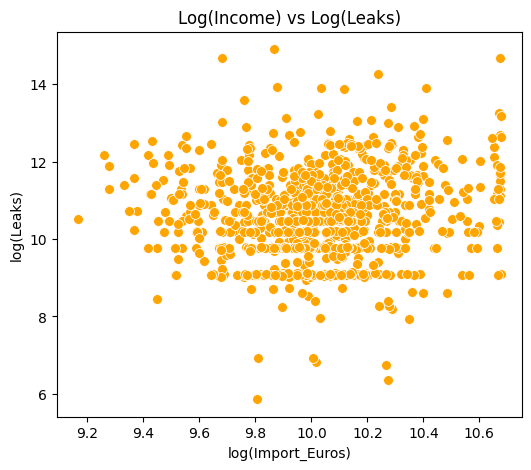

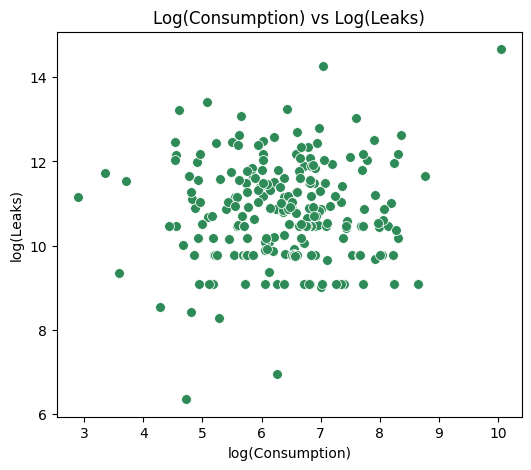

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#SCATTER PLOTS  (log transform)

# --- Create log-transformed variables ---
df_vulnerability['log_consumo'] = np.log1p(df_vulnerability['CONSUMO_REAL'])
df_vulnerability['log_fuites'] = np.log1p(df_vulnerability['num_fuites'])
df_vulnerability['log_income'] = np.log1p(df_vulnerability['Import_Euros'])

# --- 1. Log(Income) vs Log(Consumption) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='log_income', y='log_consumo', data=df_vulnerability, color='steelblue', edgecolor='white', s=50)
plt.title("Log(Income) vs Log(Consumption)")
plt.xlabel("log(Import_Euros)")
plt.ylabel("log(Consumption)")
plt.show()

# --- 2. Log(Income) vs Log(Leaks) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='log_income', y='log_fuites', data=df_vulnerability, color='orange', edgecolor='white', s=50)
plt.title("Log(Income) vs Log(Leaks)")
plt.xlabel("log(Import_Euros)")
plt.ylabel("log(Leaks)")
plt.show()

# --- 3. Log(Consumption) vs Log(Leaks) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='log_consumo', y='log_fuites', data=df_vulnerability, color='seagreen', edgecolor='white', s=50)
plt.title("Log(Consumption) vs Log(Leaks)")
plt.xlabel("log(Consumption)")
plt.ylabel("log(Leaks)")
plt.show()


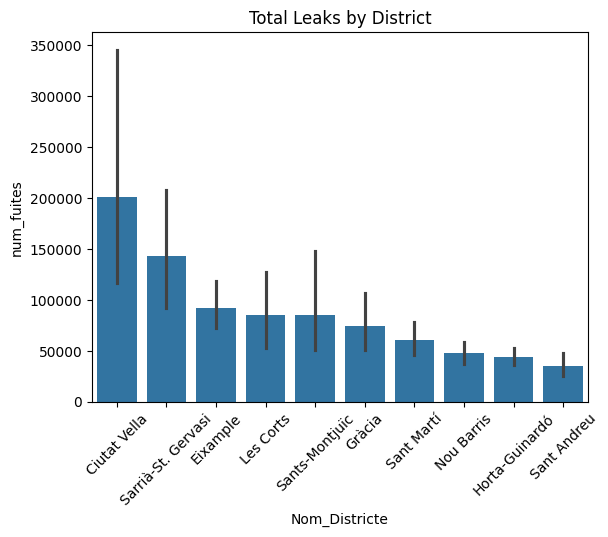

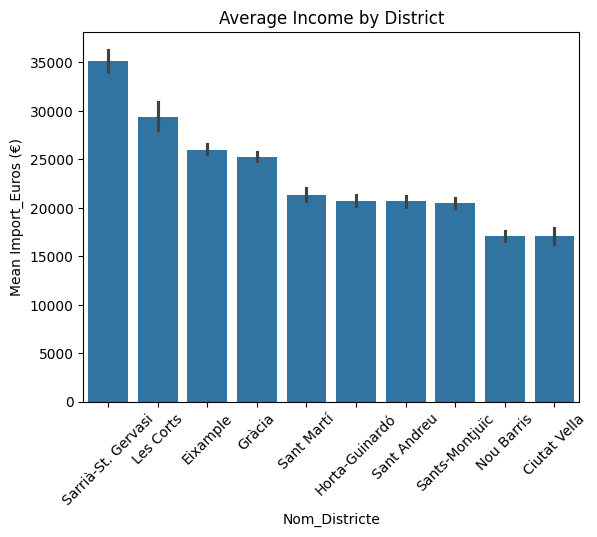

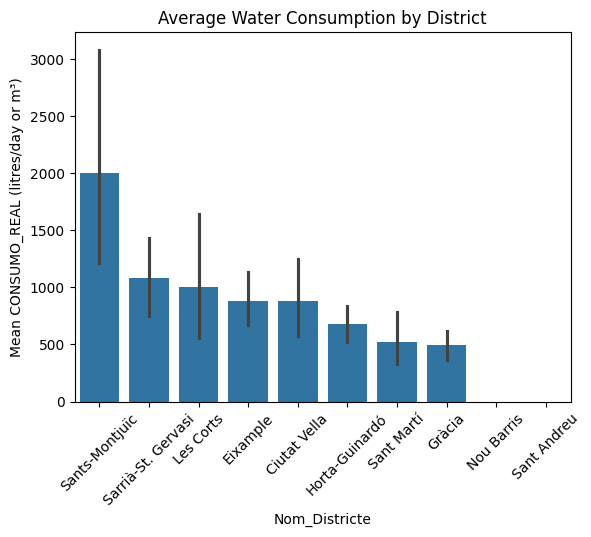

In [ ]:
# SPATIAL ANALYSIS
#Average leaks per district
sns.barplot(
    x='Nom_Districte',
    y='num_fuites',
    data=df_vulnerability,
    order=df_vulnerability.groupby('Nom_Districte')['num_fuites'].mean().sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title("Total Leaks by District")
plt.show()

# Average income per district
sns.barplot(
    x='Nom_Districte',
    y='Import_Euros',
    data=df_vulnerability,
    order=df_vulnerability.groupby('Nom_Districte')['Import_Euros']
         .mean().sort_values(ascending=False).index
)
plt.xticks(rotation=45)
plt.title("Average Income by District")
plt.ylabel("Mean Import_Euros (€)")
plt.show()

# Average consumption per district
sns.barplot(
    x='Nom_Districte',
    y='CONSUMO_REAL',
    data=df_vulnerability,
    order=df_vulnerability.groupby('Nom_Districte')['CONSUMO_REAL']
         .mean().sort_values(ascending=False).index
)
plt.xticks(rotation=45)
plt.title("Average Water Consumption by District")
plt.ylabel("Mean CONSUMO_REAL (litres/day or m³)")
plt.show()


## EDA

### Average Income per District

This can help us identify the most vulnerable districts economic-wise.

/var/folders/gy/5nns71_n7nx_v_2mkns5_k340000gn/T/ipykernel_53278/3165277242.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_socio, x="Nom_Districte", y="Import_Euros", palette="viridis")


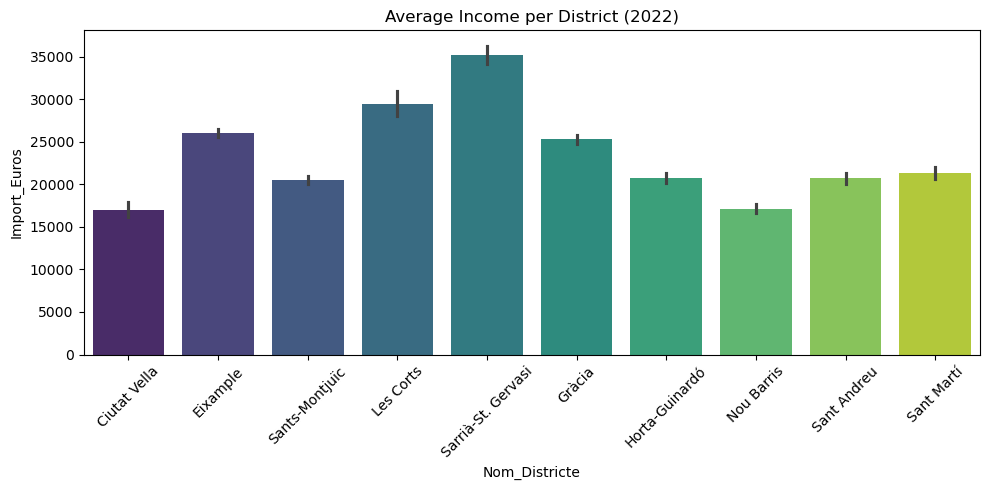

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_socio, x="Nom_Districte", y="Import_Euros", palette="viridis")
plt.title("Average Income per District (2022)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumption distribution

This can help us understand consumption trends.

In [ ]:
df_consum = pd.read_parquet("clean/consum_clean.parquet")

plt.figure(figsize=(8,4))
sns.histplot(df_consum['consumption_l_day'], bins=50, kde=True)
plt.title("Distribution of Daily Water Consumption")
plt.xlabel("Liters per Day")
plt.show()

KeyError: 'consumption_l_day'

<Figure size 800x400 with 0 Axes>

It is extremly concentrated near 0, so we should plot it in logarithmic scale. We plot it by use type to have a better overview of the consumption trends. 

In [ ]:
sns.boxplot(data=df_consum, x='use_type', y='consumption_l_day')
plt.yscale('log')  # Log scale to make differences visible
plt.title("Consumption by Use Type (Log Scale)")
plt.show()


### Distribution of leaks per month 

This can help us see if there are some time periods where there are more leaks or less. 

In [ ]:
df_fuites = pd.read_parquet("clean/fuites_clean.parquet")
df_fuites['timestamp'] = pd.to_datetime(df_fuites['timestamp'])
df_fuites['month'] = df_fuites['timestamp'].dt.to_period('M')

leaks_per_month = df_fuites.groupby('month').size().reset_index(name='num_leaks')
leaks_per_month['month'] = leaks_per_month['month'].astype(str)  

plt.figure(figsize=(10,4))
sns.lineplot(data=leaks_per_month, x='month', y='num_leaks', marker='o')
plt.title("Number of Leaks per Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Distribution of meteo data

- Temperature variation from 2022-2024.
- Monthly rainfall distribution per month (2022-2024)

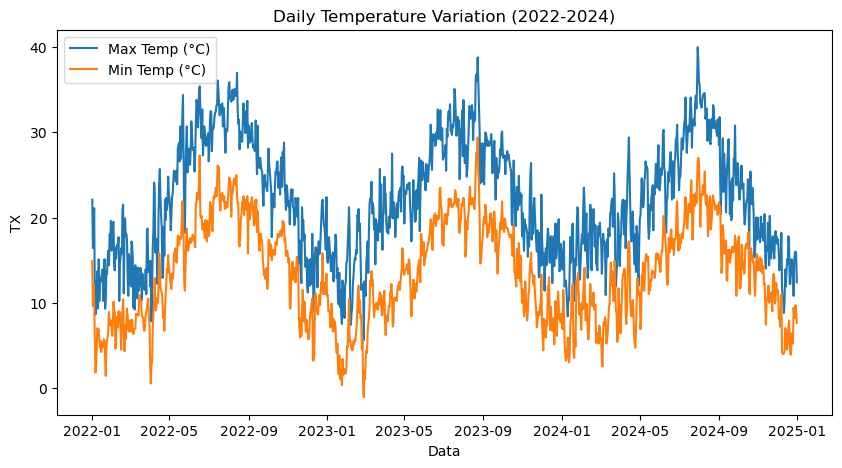

/var/folders/gy/5nns71_n7nx_v_2mkns5_k340000gn/T/ipykernel_53278/4065786337.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_meteo, x='month', y='PPT', estimator=sum, ci=None)


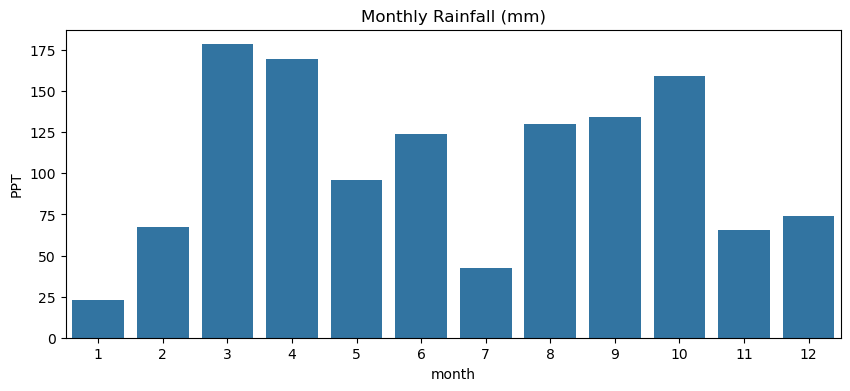

In [21]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_meteo, x='Data', y='TX', label='Max Temp (°C)', ax=ax1)
sns.lineplot(data=df_meteo, x='Data', y='TN', label='Min Temp (°C)', ax=ax1)
ax1.set_title("Daily Temperature Variation (2022-2024)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(data=df_meteo, x='month', y='PPT', estimator=sum, ci=None)
plt.title("Monthly Rainfall (mm)")
plt.show()
